# Spring 2020 CX4641/CS7641 Homework 4

## Instructor: Dr. Mahdi Roozbahani

## Deadline: Apr 21st, 11:59 pm

* You are allowed to resubmit your AS4 by 11:59pm on April 28th, 2020 without any penalty.

* Homework submission ONLY in .ipynb format.

* Discussion is encouraged on Piazza, but each student must write their own answers and explicitly mention any collaborators.

* Throughout the ipython notebook, we use attribute and feature interchangeably.

* Graduate students are required to answer the compulsory questions and the questions that are bonus for undergraduate students. There is one question that is bonus for all students.


# Environment Setup

In [1]:
import numpy as np
from collections import Counter
from scipy import stats
from math import log2, sqrt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Part 1: Utility Functions (25 pts)

## Part 1.1: Evaluation Utility Functions

Here, we ask you to develop a few functions that will be the main building blocks of your decision tree and random forest algorithms.

### Entropy and information gain [10pts]

First, we define and implement a function that computes entropy of the data.\
Then use this entropy function to compute the information gain for the partitioned data.

In [2]:
def entropy(class_y):
    """ 
    Input: 
        - class_y: list of class labels (0's and 1's)
    
    TODO: Compute the entropy for a list of classes
    Example: entropy([0,0,0,1,1,1,1,1]) = 0.9544
    """
    counts=Counter(class_y)
    entropy=0
    for c in counts:
        p=counts[c]/len(class_y)
        entropy-= (p*np.log2(p))
    return entropy

In [3]:
def information_gain(previous_y, current_y):
    """
    Inputs:
        - previous_y : the distribution of original labels (0's and 1's)
        - current_y  : the distribution of labels after splitting based on a particular
                     split attribute and split value
    
    TODO: Compute and return the information gain from partitioning the previous_y labels into the current_y labels.
    
    Reference: https://mahdi-roozbahani.github.io/CS46417641-spring2020/course/17-decision-tree.pdf

    Example: previous_y = [0,0,0,1,1,1], current_y = [[0,0], [1,1,1,0]], info_gain = 0.4591
    """ 
        
    prev_ent=entropy(previous_y)
    curr_ent=0
    
    for split in current_y:
        if(len(split)==0):
            continue
        w= len(split)/len(previous_y)
        curr_ent+= w*entropy(split)
        
    ig= prev_ent- curr_ent
    return ig

In [4]:
# TEST CASE
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))

previous_y = [0,0,0,1,1,1]
current_y = [[0,0], [1,1,1,0]] 
print(information_gain(previous_y, current_y))

0.954434002924965
0.4591479170272448


## Part 1.2: Splitting Utility Functions

Building a decision tree requires us to evaluate the best feature and value to split a node on. Now we will implement functions that help us determine these splits for the dataset.

#### (1) partition_classes: [5pts]

One of the basic operations is to split a tree on one attribute (features) with a specific value for that attribute.

In partition_classes(), we split the data (X) and labels (y) based on the split feature and value - BINARY SPLIT.

You will have to first check if the split attribute is numerical or categorical. If the split attribute is numeric, split_val should be a numerical value. For example, your split_val should go over all the values of attributes. If the split attribute is categorical, split_val should include all the categories one by one.   
    
You can perform the partition in the following way:
   - Numeric Split Attribute:
   
       Split the data X into two lists(X_left and X_right) where the first list has all
       the rows where the split attribute is less than or equal to the split value, and the 
       second list has all the rows where the split attribute is greater than the split 
       value. Also create two lists(y_left and y_right) with the corresponding y labels.
    
   - Categorical Split Attribute:
   
       Split the data X into two lists(X_left and X_right) where the first list has all 
       the rows where the split attribute is equal to the split value, and the second list
       has all the rows where the split attribute is not equal to the split value.
       Also create two lists(y_left and y_right) with the corresponding y labels.


Hint: You could find out if the feature is categorical by checking if it is the instance of 'str'

In [5]:
def partition_classes(X, y, split_attribute, split_val):
    """
    Inputs:
    - X               : (N,D) list containing all data attributes
    - y               : a list of labels
    - split_attribute : column index of the attribute to split on
    - split_val       : either a numerical or categorical value to divide the split_attribute
    
    TODO: Partition the data(X) and labels(y) based on the split value - BINARY SPLIT.
    
    Example:
    
    X = [[3, 'aa', 10],                 y = [1,
         [1, 'bb', 22],                      1,
         [2, 'cc', 28],                      0,
         [5, 'bb', 32],                      0,
         [4, 'cc', 32]]                      1]
    
    Here, columns 0 and 2 represent numeric attributes, while column 1 is a categorical attribute.
    
    Consider the case where we call the function with split_attribute = 0 (the index of attribute) and split_val = 3 (the value of attribute).
    Then we divide X into two lists - X_left, where column 0 is <= 3 and X_right, where column 0 is > 3.
    
    X_left = [[3, 'aa', 10],                 y_left = [1,
              [1, 'bb', 22],                           1,
              [2, 'cc', 28]]                           0]
              
    X_right = [[5, 'bb', 32],                y_right = [0,
               [4, 'cc', 32]]                           1]

    Consider another case where we call the function with split_attribute = 1 and split_val = 'bb'
    Then we divide X into two lists, one where column 1 is 'bb', and the other where it is not 'bb'.
        
    X_left = [[1, 'bb', 22],                 y_left = [1,
              [5, 'bb', 32]]                           0]
              
    X_right = [[3, 'aa', 10],                y_right = [1,
               [2, 'cc', 28],                           0,
               [4, 'cc', 32]]                           1]
               
               
    Return in this order: X_left, X_right, y_left, y_right       
    """   
    
    X_left= []
    X_right= []
    y_left= []
    y_right= []
    
    Xy=np.hstack((X,np.array([y]).T))
    
    if(isinstance(split_val, str)):
        Xy_left=Xy[np.where(Xy[:,split_attribute] == split_val)]
        Xy_right=Xy[np.where(Xy[:,split_attribute] != split_val)]
    else:
        Xy_left=Xy[np.where(Xy[:,split_attribute] <= split_val)]
        Xy_right=Xy[np.where(Xy[:,split_attribute] > split_val)]
    
    """
    for i, point in enumerate(X):
        if(isinstance(split_val, str)):
            if(point[split_attribute]==split_val):
                X_left.append(point)
                y_left.append(y[i])
            else:
                X_right.append(point)
                y_right.append(y[i])
        else:
            temp=int(point[split_attribute])
            if(temp<=split_val):
                X_left.append(point)
                y_left.append(y[i])
            else:
                X_right.append(point)
                y_right.append(y[i])
    """
    
    X_left= Xy_left[:,:-1]
    X_right= Xy_right[:,:-1]
    y_left= Xy_left[:,-1]
    y_right= Xy_right[:,-1]
    return X_left, X_right, y_left, y_right

#### (2) find_best_split [5pts]

Given the data and labels, we need to find the order of splitting features, which is also the importance of the feature. For each attribute (feature), we need to calculate its optimal split value along with the corresponding information gain and then compare with all the features to find the optimal attribute to split.

First, we specify an attribute. After computing the corresponding information gain of each value at this attribute list, we can get the optimal split value, which has the maximum information gain.

In [6]:
def find_best_split(X, y, split_attribute):
    """Inputs:
        - X               : (N,D) list containing all data attributes
        - y               : a list array of labels
        - split_attribute : Column of X on which to split
    
    TODO: Compute and return the optimal split value for a given attribute, along with the corresponding information gain
    
    Note: You will need the functions information_gain and partition_classes to write this function
    
    Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           split_val = 1  -->  info_gain = 0.17
           split_val = 2  -->  info_gain = 0.01997
           split_val = 3  -->  info_gain = 0.01997
           split_val = 4  -->  info_gain = 0.32
           split_val = 5  -->  info_gain = 0
        
       best_split_val = 4; info_gain = .32; 
    """
    sv_vals=list(set(X[:,split_attribute]))
    best_split_val=""
    best_ig=0
    for sv in sv_vals:
        X_left, X_right, y_left, y_right=partition_classes(X, y, split_attribute, sv)
        ig= information_gain(y, [y_left,y_right])
        if(ig>best_ig):
            best_ig=ig
            best_split_val=sv
    return best_split_val,best_ig

#### (3)  find_best_feature [5pts]

Based on the above functions, we can find the most important feature that we will split first.

In [7]:
def find_best_feature(X, y):
    """
    Inputs:
        - X: (N,D) list containing all data attributes
        - y : a list of labels
    
    TODO: Compute and return the optimal attribute to split on and optimal splitting value
    
    Note: If two features tie, choose one of them at random
    
    Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           feature 0:  -->  info_gain = 0.32
           feature 1:  -->  info_gain = 0.17
           feature 2:  -->  info_gain = 0.4199
        
       best_split_feature: 2 best_split_val: 22
    """
    
    #  Delete this line when you implement the function
    best_att=0
    best_sv=""
    best_ig=0
    for att in range(X.shape[1]):
        sv,ig= find_best_split(X, y, att)
        if(ig>best_ig):
            best_ig=ig
            best_sv=sv
            best_att=att
    return best_att, best_sv

In [8]:
# TEST CASE
test_X = [[3, 'aa', 10],[1, 'bb', 22],[2, 'cc', 28],[5, 'bb', 32],[4, 'cc', 32]]
test_y = [1,1,0,0,1]
test_X, test_y = np.array(test_X, dtype='object'), np.array(test_y)
print(partition_classes(test_X, test_y, 0, 3))
print(partition_classes(test_X, test_y, 1, 'bb'))

split_attribute = 0
best_split_val, info_gain = find_best_split(test_X, test_y, split_attribute)
print("best_split_val:", best_split_val, "info_gain:", info_gain)

best_feature, best_split_val = find_best_feature(test_X, test_y)
print("best_split_feature:", best_feature, "best_split_val:", best_split_val)

(array([[3, 'aa', 10],
       [1, 'bb', 22],
       [2, 'cc', 28]], dtype=object), array([[5, 'bb', 32],
       [4, 'cc', 32]], dtype=object), array([1, 1, 0], dtype=object), array([0, 1], dtype=object))
(array([[1, 'bb', 22],
       [5, 'bb', 32]], dtype=object), array([[3, 'aa', 10],
       [2, 'cc', 28],
       [4, 'cc', 32]], dtype=object), array([1, 0], dtype=object), array([1, 0, 1], dtype=object))
best_split_val: 4 info_gain: 0.3219280948873623
best_split_feature: 2 best_split_val: 22


# Part 2: Decision Tree (20 pts)
## Please read the following instructions carefully before you dive into coding

In this part, you will implement your own ID3 decision tree class and make it work on training and test set (ID3 is the name of the algorithm to construct the decision tree).

You may use a recursive way to construct the tree and make use of helper functions in Part1. 

Please keep in mind that we use information gain to find the best feature and value to split the data for ID3 tree.

To save your training time, we have added a ```max_depth``` parameter to control the maximum depth of the tree. You may adjust its value to pre-prune the tree. If set to None, it has no control of depth.

You need to have a stop condition for splitting. The stopping condtion is reached when one of the two following conditions are met:
1. If all data points in that node have the same label
2. If the current node is at the maximum depth. In this case, you may assign the mode of the labels as the class label

The MyDecisionTree class should have some member variables. We highly encourage you to use a [dict data structure](https://www.w3schools.com/python/python_dictionaries.asp) in Python to store the tree information. For leaves nodes, this dict may have just one element representing the class label. For non-leaves node, the list should at least store the feature and value to split, and references to its left and right child.

An example of the dict that you may use for non-leaf nodes:

<pre> node = {
            'isLeaf': False,
            'split_attribute': split_attribute,
            'split_value': split_val,
            'is_categorical': is_categorical,
            'leftTree': leftTree,
            'rightTree': rightTree
        };
</pre>

In the above example, the leftTree and rightTree are instances of MyDecisonTree itself.

### If you use different ways to represent and store the information, please include clear comments or documentations with your code. If your result is not correct, partial credits can only be awarded if we are able to understand your code

In [9]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):
        """
        TODO: Initializing the tree as an empty dictionary, as preferred.
        
        For example: self.tree = {}
        
        Args:
        
        max_depth: maximum depth of the tree including the root node.
        """
        
        # label -1 indicates not a leaf
        self.tree = {
            'label': -1,
            'split_attribute': None,
            'split_value': None,
            'leftTree': None,
            'rightTree': None
        }
        self.max_depth=max_depth
        if(max_depth==None):
            self.max_depth=np.inf

    def fit(self, X, y, depth):
        """
        TODO: Train the decision tree (self.tree) using the the sample X and labels y.
        
        NOTE: You will have to make use of the utility functions to train the tree.
        One possible way of implementing the tree: Each node in self.tree could be in the form of a dictionary:
        https://docs.python.org/2/library/stdtypes.html#mapping-types-dict
        
        For example, a non-leaf node with two children can have a 'left' key and  a  'right' key. 
        You can add more keys which might help in classification (eg. split attribute and split value)
        
        
        While fitting a tree to the data, you will need to check to see if the node is a leaf node(
        based on the stopping condition explained above) or not. 
        If it is not a leaf node, find the best feature and attribute split:
        X_left, X_right, y_left, y_right, for the data to build the left and
        the right subtrees.
        
        Remember for building the left subtree, pass only X_left and y_left and for the right subtree,
        pass only X_right and y_right.
        
        Args:
        
        X: N*D matrix corresponding to the data points
        Y: N*1 array corresponding to the labels of the data points
        depth: depth of node of the tree
        
        """
        if(depth==self.max_depth or len(set(y))==1):
            self.tree["label"]=stats.mode(y)[0][0]
            return
            
        best_att, best_sv= find_best_feature(X, y)
        X_left, X_right, y_left, y_right= partition_classes(X, y, best_att, best_sv)
        self.tree["split_attribute"]=best_att
        self.tree["split_value"]=best_sv
        self.tree["leftTree"]= MyDecisionTree(self.max_depth)
        self.tree["rightTree"]=MyDecisionTree(self.max_depth)
        self.tree["leftTree"].fit(X_left,y_left,depth+1)
        self.tree["rightTree"].fit(X_right,y_right,depth+1)
           
       
    def predict(self, record):
        """
        TODO: classify a sample in test data set using self.tree and return the predicted label
        
        Args:
        
        record: D*1, a single data point that should be classified
        
        Returns: True if the predicted class label is 1, False otherwise      
        
        
        """
        if(self.tree["label"]!=-1):
            return self.tree["label"]
        att=self.tree["split_attribute"]
        sv=self.tree["split_value"]
        if(isinstance(sv, str)):
            if(record[att]==sv):
                return self.tree["leftTree"].predict(record)
            else:
                return self.tree["rightTree"].predict(record)
        else:
            if(record[att]<=sv):
                return self.tree["leftTree"].predict(record)
            else:
                return self.tree["rightTree"].predict(record)
        

In [10]:
# helper function. You don't have to modify it
def DecisionTreeEvalution(dt,X,y, verbose=False):

    # Make predictions
    # For each test sample X, use our fitting dt classifer to predict
    y_predicted = []
    for record in X: 
        y_predicted.append(dt.predict(record))

    # Comparing predicted and true labels
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)]

    # Accuracy
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy
    

### Dataset Objective

We are quant researchers in a new credit company, "50K Credit". We are tasked with the responsibility of coming up with a screening system that lets our employees know if an individual is eligible for the "new and exciting" credit card that our company is going to launch in July 2020.

After much deliberation amongst all researchers, you come to a conclusion that any individual that earns more than $50K annually should be given the credit card.

Our task is to use the decision tree algorithm to predict if an individual earns more than $50K annually and is therefore eligible for the new credit card.

### Loading the dataset


The dataset that the company has collected has the following features:

1. age : continuous variable
2. state_sample	: continuous variable
3. education_num : continuous variable
4. capital_gain : continuous variable
5. capital_loss : continuous variable
6. hours_per_week : continuous variable
7. workclass : categorical variable
8. education : categorical variable
9. marital_status : categorical variable
10. occupation : categorical variable
11. relationship	: categorical variable
12. c1	: categorical variable
13. c2	: categorical variable
14. c3 : categorical variable

In [11]:
# helper function. You don't have to modify it
data_test = pd.read_csv("hw4_spring2020_data_test.csv")
data_valid = pd.read_csv("hw4_spring2020_data_valid.csv")
data_train = pd.read_csv("hw4_spring2020_data_train.csv")

categorical = ['workclass', 'education', 'marital_status', 'occupation', 
                   'relationship', 'c1', 'c2', 'c3']
numerical = ['age', 'state_sample', 'education_num','capital_gain', 'capital_loss',
                'hours_per_week']
 
X_train = pd.concat([data_train[categorical], data_train[numerical]], axis=1)
y_train = data_train['eligible']
X_test = pd.concat([data_test[categorical], data_test[numerical]], axis=1)
y_test = data_test['eligible']
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

X_valid = pd.concat([data_valid[categorical], data_valid[numerical]], axis=1)
y_valid = data_valid['eligible']
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

Let us train and evaluate the performance of our decision tree on the test set. Note that it is trivially possible to achieve 75% accuracy because of the disribution of "eligible" candidates in the dataset. You should aim to get an accuracy of atleast 80% on the test set.

In [12]:
# Initializing a decision tree.
max_depth = 7
dt = MyDecisionTree(max_depth)

# Building a tree
print("fitting the decision tree")
dt.fit(X_train, y_train, 0)

# Evaluating the decision tree
DecisionTreeEvalution(dt,X_test,y_test, True)

fitting the decision tree
accuracy: 0.8474


0.8473864515416069

---------
# Part 3
## Pruning [10 Pts] [Bonus for undergrads]

In order to avoid overfitting, you can:
1. Acquire more training data; 
2. Remove irrelevant attributes; 
3. Grow full tree, then post-prune; 
4. Ensemble learning. 

In this part, you are going to apply reduced error post-pruning to prune the fully grown tree in a bottom-up manner.
The idea is basically about, starting at the leaves, each node is replaced with its most popular class. If the prediction accuracy is not affected then the change is kept. You may also try recursive function to apply the post-pruning. Please notice we use validation set to get the accuracy for each node during the pruning

In [13]:
def DecisionTreeError(y):
    # helper function for calculating the error of the entire subtree if converted to a leaf with majority class label.
    # You don't have to modify it  
    num_ones = np.sum(y)
    num_zeros = len(y) - num_ones
    return 1.0 - max(num_ones, num_zeros) / float(len(y))


#  Define the post-pruning function
def pruning(dt, X, y):
    """
    TODO:
    1. Prune the full grown decision tress recursively in a bottom up manner.  
    2. Classify examples in validation set.
    3. For each node: 
    3.1 Sum errors over the entire subtree. You may want to use the helper function "DecisionTreeEvalution".
    3.2 Calculate the error on same example if converted to a leaf with majority class label. 
    You may want to use the helper function "DecisionTreeError".
    4. If error rate in the subtree is greater than in the single leaf, replace the whole subtree by a leaf node.
    5. Return the pruned decision tree.
    """
    
    if(dt.tree["label"]!=-1):
        return dt
    if(len(y)==0):
        dt.tree["label"]=0
        return dt
    
    att=dt.tree["split_attribute"]
    sv=dt.tree["split_value"]
    X_left, X_right, y_left, y_right= partition_classes(X, y, att, sv)
    pruning(dt.tree["leftTree"],X_left,y_left)
    pruning(dt.tree["rightTree"],X_right,y_right)
    tree_error= 1-DecisionTreeEvalution(dt,X,y)
    leaf_error= DecisionTreeError(y)
    if(tree_error>leaf_error):
        dt.tree["label"]=stats.mode(y)[0][0]
    return dt

Now, you should make use of the decision tree you trained in part1. Due the imbalance in our dataset, the post-pruning does not necessarily have better accuracy on test set. However, you will receive a free lunch after post-pruning. The free lunch is a more efficient algorithm. We will award full credits as long as your implementation is correct.

In [14]:
# helper function. You don't have to modify it.
# pruning the full grown decision tree using validation set 
# dt should be a decision tree object that has been fully trained
dt_pruned=pruning(dt, X_valid, y_valid)

# Evaluate the decision tree using test set 

DecisionTreeEvalution(dt_pruned, X_test, y_test, False)

0.8491546027185324

# Part 4: Random Forests [35pts]

The decision boundaries drawn by decision trees are very sharp, and fitting a decision tree of unbounded depth to a list of examples almost inevitably leads to **overfitting**. In an attempt to decrease the variance of our classifier we're going to use a technique called 'Bootstrap Aggregating' (often abbreviated 'bagging'). This stems from the idea that a collection of weak learners can learn decision boundaries as well as a strong learner.


## Part 4.1 Random Forest Implementation (30pts)


A Random Forest is a collection of decision trees, built as follows (**VERY IMPORTANT**):

1) For every tree we're going to build:

    a) Subsample the examples with replacement. Note that in this question, the size of the subsample data is equal to the original dataset. 
    
    b) From the subsamples in a), choose attributes at random to learn on in accordance with a provided attribute subsampling rate. Based on what it was mentioned in the class, we randomly pick features in each split. We use a more general approach here to make the programming part easier. Let's randomly pick some features (70% percent of features) and grow the tree based on the pre-determined randomly selected features. Therefore, there is no need to find random features in each split.
    
    c) Fit a decision tree to the subsample of data we've chosen to a certain depth.
    
Classification for a random forest is then done by taking a majority vote of the classifications yielded by each tree in the forest after it classifies an example.

In RandomForests Class, 
1. X is assumed to be a matrix with num_training rows and num_features columns where num_training is the
number of total records and num_features is the number of features of each record. 

2. y is assumed to be a vector of labels of length num_training.

**NOTE:** Lookout for TODOs for the parts that needs to be implemented.

In [15]:
"""
NOTE: For graduate student, you are required to use your own decision tree MyDecisionTree() to finish random forest.
"""

class RandomForest(object):
    def __init__(self, n_estimators=50, max_depth=None, max_features=0.7):
        # helper function. You don't have to modify it
        # Initialization done here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstraps_row_indices = []
        self.feature_indices = []
        self.out_of_bag = []
        self.decision_trees = [MyDecisionTree(max_depth=max_depth) for i in range(n_estimators)]
        
    def _bootstrapping(self, num_training, num_features):
        """
        TODO: 
        - Randomly select a sample dataset of size num_training with replacement from the original dataset. 
        - Randomly select certain number of features (num_features denotes the total number of features in X, 
          max_features denotes the percentage of features that are used to fit each decision tree) without replacement from the total number of features.
        
        Return:
        - row_idx: the row indices corresponding to the row locations of the selected samples in the original dataset.
        - col_idx: the column indices corresponding to the column locations of the selected features in the original feature list.
        
        Reference: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
        """ 
        row_idx=np.random.randint(num_training, size=num_training)
        fs=int(self.max_features*num_features)
        col_idx=np.random.choice(num_features, fs, replace=False)
        return row_idx, col_idx
            
    def bootstrapping(self, num_training, num_features):
        # helper function. You don't have to modify it
        # Initializing the bootstap datasets for each tree
        for i in range(self.n_estimators):
            total = set(list(range(num_training)))
            row_idx, col_idx = self._bootstrapping(num_training, num_features)
            total = total - set(row_idx)
            self.bootstraps_row_indices.append(row_idx)
            self.feature_indices.append(col_idx)
            self.out_of_bag.append(total)

    def fit(self, X, y):
        """
        TODO:
        Train decision trees using the bootstrapped datasets.
        Note that you need to use the row indices and column indices.
        """
        self.bootstrapping(len(y),X.shape[1])
        for i in range(self.n_estimators):
            row_idx=self.bootstraps_row_indices[i]
            col_idx=self.feature_indices[i]
            dt=self.decision_trees[i]
            rX=X[row_idx]
            new_X=rX[:,col_idx]
            new_y=y[row_idx]
            dt.fit(new_X,new_y,0)
        
    
    def OOB_score(self, X, y):
        # helper function. You don't have to modify it
        accuracy = []
        for i in range(len(X)):
            predictions = []
            for t in range(self.n_estimators):
                if i in self.out_of_bag[t]:
                    predictions.append(self.decision_trees[t].predict(X[i][self.feature_indices[t]]))
            if len(predictions) > 0:
                accuracy.append(np.sum(predictions == y[i]) / float(len(predictions)))
        return np.mean(accuracy)

## Part 4.2 Hyperparameter tuning(5pts)

Change the hyperparamters below to obtain atleast a 83% accuracy of the test dataset

In [16]:
"""
TODO: 
n_estimators defines how many decision trees are fitted for the random forest (at least 10). 
max_depth defines a stop condition when the tree reaches to a certain depth.
max_features controls the percentage of features that are used to fit each decision tree.
Tune these three parameters to achieve a better accuracy (Required min. accuracy is 0.83.)
The random forest fitting may take 5 - 15 minutes. We will not take running time into account when grading this part.
"""
n_estimators = 10
max_depth = 5
max_features = 1

random_forest = RandomForest(n_estimators, max_depth, max_features)

random_forest.fit(X_train, y_train)
accuracy=random_forest.OOB_score(X_test, y_test)

print("accuracy: %.4f" % accuracy)

accuracy: 0.8409


# Part 5: SVM (35 Pts + 15 Pts Bonus)

## 5.1 Fitting an SVM classifier by hand (20 Pts)

Consider a dataset with 2 points in 1-dimensional space: $(x_1 = -2, y_1 = −1)$ and $(x_2 = 1, y_2 = 1)$. Here $x$ are the point coordinates and $y$ are the classes.

Consider mapping each point to 3-dimensional space using the feature vector $\phi(x) = [1,2x, x^2]$. (This is equivalent to using a second order polynomial kernel.) The max margin classifier has the form

$$min ||\mathbf{\theta}||^2 s.t.$$

$$y_1(\phi(x_1)\mathbf{\theta} + b) ≥ 1 $$

$$y_2(\phi(x_2)\mathbf{\theta}+ b) ≥ 1 $$

**Hint:** $\phi(x_1)$ and $\phi(x_2)$ are the suppport vectors. We have already given you the solution for the suppport vectors and you need to calculate back the parameters. Margin is equal to $\frac{1}{||\mathbf{\theta}||}$ and full margin is equal to $\frac{2}{||\mathbf{\theta}||}$.

(1) Find a vector parallel to the optimal vector $\mathbf{\theta}$. (4pts)
<br>
<font color='red'>
     $\phi(x_1) = [1,-4, 4]$ and $\phi(x_2) = [1,2, 1]$<br><br> 
     A vector parallel to the optimal vector would be $\phi(x_2)-\phi(x_1) = [1,2, 1]- [1,-4, 4] = [0,6,-3]$
</font>
<br>
<br>

(2) Calculate the value of the margin achieved by this $\mathbf{\theta}$? (4pts)
<br>
<font color='red'>
     $margin = \frac{\sqrt{(0)^2+(6)^2+(-3)^2}}{2}=\frac{\sqrt{45}}{2}=\frac{3\sqrt{5}}{2}$
</font>
<br>
<br>

(3) Solve for $\mathbf{\theta}$, given that the margin is equal to $1/||\mathbf{\theta}||$. (4pts)
<br>
<font color='red'>
     $\theta=[0,6a,-3a]$ and $\frac{1}{||\theta||}=\frac{3\sqrt{5}}{2}$<br><br>
     so $\sqrt{(0)^2+(6a)^2+(-3a)^2}=\frac{2}{3\sqrt{5}}$,<br><br>
     $3\sqrt{5}a=\frac{2}{3\sqrt{5}}$,<br><br>
     so a=$\frac{2}{45}$<br><br>
     and $\theta=[0,\frac{4}{15},-\frac{2}{15}]$
</font>
<br>
<br>

(4) Solve for $b$ using your value for $\mathbf{\theta}$. (4pts)
<br>
<font color='red'>
     $y_1(\phi(x_1)\theta+b)=1$<br><br>
     $(1)([1,2,1]^T*[0,\frac{4}{15},-\frac{2}{15}]+b)=1$<br><br>
     $\frac{8}{15}-\frac{2}{15}+b=1$<br><br>
     $b=\frac{9}{15}= \frac{3}{5}$
</font>
<br>
<br>

(5) Write down the form of the discriminant function $f(x) = \phi(x)\mathbf{\theta}+b$ as an explicit function of $x$. (4pts)
<br>
<font color='red'>
     $f(x)=\theta_0 + \theta^T\phi(x)$<br><br>
     $f(x)=\frac{3}{5} + [0,\frac{4}{15},-\frac{2}{15}]^T[1,2x,x^2]$<br><br>
     $f(x)=\frac{3}{5} + \frac{8}{15}x-\frac{2}{15}x^2$
</font>
<br>
<br>

## 5.2 SVM Kernel (15 Pts)

(1) (5 points) We know that SVM can be used to classify linearly inseparable data by transforming it to a different feature space with a kernel $K(x, z) = \phi(x)^T \phi(z)$, where $\phi(x)$ is a feature mapping ($x$ and $z$ are both data points). Let $K_1$ and $K_2$ be $R^n \times R^n$ kernels, $c \in R^+$ be a positive constant., and $\phi_1,\phi_2 : R^n → R^d$ be the respective feature mappings of $K_1$ and $K_2$. Explain how to use $\phi_1,\phi_2$ to obtain the following kernels:   
a. $K(x, z) = cK_1(x, z)$
<br>
<font color='red'>
     $K(x, z) = cK_1(x, z)$<br><br>
     $\phi(x)^T \phi(z) = c\phi_1(x)^T \phi_1(z)$<br><br>
     $\phi(x)^T \phi(z) = (\sqrt{c}\phi_1(x)^T)* (\sqrt{c}\phi_1(z))$<br><br>
     $\phi(x)= \sqrt{c}\phi_1(x)$
</font>
<br>
<br>
b. $K(x, z) = K_1(x, z)K_2(x, z)$
<br>
<font color='red'>
     $K(x, z) = K_1(x, z)K_2(x, z)$<br><br>
     $\phi(x)^T \phi(z) = (\phi_1(x)^T \phi_1(z))*(\phi_2(x)^T \phi_2(z))$<br><br>
     $\phi(x)^T \phi(z) = (\phi_1(x)^T \phi_2(x)^T)*(\phi_1(z) \phi_2(z))$<br><br>
     $\phi(x)= \phi_1(x) \phi_2(x)$
</font>
<br>
<br>

(2) (10 points)  
a. Consider the polynomial kernel $$K(x,z) = (x^T z + 1)^d$$ with d=2. Let $x,z \in R$ for simplicity. Define one calculation as one multiplication, addition or square operation. Assume that constants (like $\sqrt{2}$) are already calculated and given. What is the number of calculations required to find $K(x,z)$ through direct computation?
<br>
<font color='red'>
    You would need <strong> 3 </strong> calculations. 1 multiplication $(x*z)$, 1 addition $(prev +1)$, 1 square $(prev)^2$.
</font>
<br>
<br>
b. Can you find the corresponding feature mapping $\phi(x)$?
<br>
<font color='red'>
    $K(x,z) = (x^T z + 1)^d$ with d=2<br><br>
    $\phi(x)^T \phi(z) = (x^T)^2(z)^2 +2x^Tz+1$<br><br>
    $\phi(x)^T \phi(z) = [(x^T)^2,x^T\sqrt{2},1] * [z^2,z\sqrt{2},1]$<br><br>
    so, $\phi(x)= [x^2,x\sqrt{2},1]$
</font>
<br>
<br>

c. What is the number of calculations (count for different operations: addition, multiplication and square) required for calculating the above feature map for a scalar $x$ ?
<br>
<font color='red'>
    The feature mapping would need <strong> 2 </strong> calculations. 1 square $(x^2)$ and 1 multiplication $(x*\sqrt{2})$.
</font>
<br>
<br>
d. What is the number of calculations to find $K(x,z)$ using $\phi(x)^T \phi(z)$? Comment on this with respect to your answer in (a).
<br>
<font color='red'>
    This would require <strong> 9 </strong> calculations. 1 square and 1 multiplication for feature mapping for both x and z(4), 1 multiplication for each of the 3 dimentions of the mapped feature (3), 2 additions that sum up the dot product addends (2). So overall 4+3+2= 9. This has 3 times more calculations required than part a, as it has 3 time the number of dimensions.
</font>
<br>
<br>
e. Consider the Radial Basis Kernel $$K(x,z) = exp ( - \frac{||x - z||^2} {2\sigma^2})$$. Is it possible to find a feature map in this case? Do you think it's necessary that an explicit feature map exists with all kernels?  
<br>
<font color='red'>
    It would <strong>not be possible </strong> to derive a feature map for this case, as it would be infinite dimensional, even though an implicit feature map would exsist. <strong>It is not necessary that an explicit feature map exists </strong>because or program can compute an implicit feature mapping and work around that. 
</font>
<br>
<br>

## 5.3 SVM Implementation (15 Pts - Bonus for all)



Please read the following instructions carefully and also read the descriptions given in function docstring.

In this part, you will implement your own SVM classifier and do some feature engineering to work with non-linear decision boundaries.

The "reg" parameter passed to the class is to be used with the hinge loss i.e. 
$$
\begin{equation}
       \text{hinge_loss} = \text{reg} \cdot \frac{1}{N} \sum_{i=1}^N \max(0, 1 - y_i(x_i \cdot \theta))
\end{equation}
$$

And similarly, should also be included in the gradient used in update rule for $W$.

The maximum number of epochs is set to 5000 but the model shouldn't take that many epochs to converge. You should check if the update changes cost by more than previous cost times the eps parameter and stop the iteration if not.

In [17]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import numpy as np

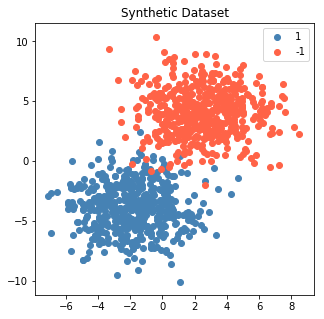

In [18]:
filename = 'svm_data_1.npz'
# np.savez(filename, X, y)

npz_data = np.load(filename)
X = npz_data['arr_0']
y = npz_data['arr_1']

f, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))

plt.scatter(X[y==1,0],X[y==1,1], color='steelblue', label='1')
plt.scatter(X[y==-1,0],X[y==-1,1], color='tomato', label='-1')
plt.legend()
ax.set_title("Synthetic Dataset");

In [19]:
class SVM(object):
    def __init__(self, reg = 1000, lr = 1e-8, eps=0.01, print_every=20):
        '''
        You don't have to modify this function
        Initialization done here
        '''
        
        self.W = None
        self.reg = reg
        self.lr = lr
        self.eps = eps
        self.print_every = 20
    
    def compute_cost(self, X, y):
        '''
        TODO - Compute the total cost function for SVM
        
        returns:
            cost - float, total value of cost function
        '''
        # calculate hinge loss
        dist= 1- y * (np.dot(X, self.W))
        dist[dist < 0] = 0
        hl= self.reg * (np.sum(dist)/len(y))

        # calculate cost
        cost = 0.5 * np.dot(self.W, self.W) + hl
        return cost
    
    def calculate_cost_gradient(self, X_point, y_point):
        '''
        TODO - Compute the total cost function for SVM
        
        returns:
            dW - (D, ) array of piecewise gradient of SVM loss 
                 function
        '''
        dist= 1-y_point*np.dot(X_point, self.W)
        dw= np.zeros(len(self.W))
        if dist<=0:
            dw = self.W
        else:
            dw = self.W -(self.reg * y_point * X_point)
        return dw
    
    def fit(self, X_train, y_train):
        '''
        TODO - Use SGD to fit W to data using SVM update rule.
        
        You should use calculate_cost_gradient function
        to get the gradient for update rule and compute_cost
        function to get cost which can be displayed after 
        every few epochs. 
        
        features doesn't include 1's for bias term. It 
        needs to be separately accounted for in your code.
        
        Use eps, print_every and lr defined in __init__()
        
        Update self.W directly.
        
        returns: None
        '''
        max_epochs= 5000
        prev_cost= np.inf
        oc= np.array([np.ones(X_train.shape[0])]).T
        #print(oc.shape)
        #print(X_train.shape)
        X_train= np.hstack((oc,X_train))
        self.W= np.zeros(X_train.shape[1])
        
        for epoch in range(max_epochs):
            for i in range(len(y_train)):
                dw= self.calculate_cost_gradient(X_train[i], y_train[i])
                self.W = self.W-(self.lr * dw)
            if (epoch%self.print_every==0  or epoch==max_epochs-1):
                cost= self.compute_cost(X_train, y_train)
                print("Epoch is:{} and Cost is: {}".format(epoch, cost))
                if abs(prev_cost - cost) < self.eps * prev_cost:
                    return self.W
                prev_cost = cost
        return self.W

        
        
    def predict(self, X_test):
        '''
        TODO - Predict y_test from W updated in fit function.
        
        X_test doesn't include 1's for bias term. It 
        needs to be separately accounted for in your code.
        
        returns: 
            y_test_predicted: (N, ) array predicted by model 
                              with values from {-1, 1} 
        '''
        #  Delete this line when you implement the function
        oc= np.array([np.ones(X_test.shape[0])]).T
        X_test= np.hstack((oc,X_test))
        y_test_predicted=np.sign(np.dot(X_test,self.W))
        return y_test_predicted

In [20]:
# DO NOT CHANGE
# Train the SVM classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

svm_cls = SVM()
svm_cls.fit(X_train, y_train)

Epoch is:0 and Cost is: 834.0299552475043
Epoch is:20 and Cost is: 94.10329006250495
Epoch is:40 and Cost is: 69.4999916809166
Epoch is:60 and Cost is: 60.46860734766459
Epoch is:80 and Cost is: 55.204285882492606
Epoch is:100 and Cost is: 51.72603969368006
Epoch is:120 and Cost is: 49.091423068890286
Epoch is:140 and Cost is: 47.13395087720192
Epoch is:160 and Cost is: 45.58485742245451
Epoch is:180 and Cost is: 44.45594204501737
Epoch is:200 and Cost is: 43.40785732419747
Epoch is:220 and Cost is: 42.50902548609815
Epoch is:240 and Cost is: 41.68589574821598
Epoch is:260 and Cost is: 40.995952070626345
Epoch is:280 and Cost is: 40.43095708021257
Epoch is:300 and Cost is: 39.936974926679426
Epoch is:320 and Cost is: 39.561309343654415


array([ 0.03524742, -0.26222667, -0.53343086])

In [21]:
# DO NOT CHANGE
# Check test accuracy
# You should get more than 90% accuracy

y_test_predicted = svm_cls.predict(X_test)

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, 
                                                           y_test_predicted)))

Accuracy on test dataset: 0.98


In [22]:
def visualize_decision_boundary(X, y, feature_new=None, h=0.02):
    '''
    You don't have to modify this function
    
    Function to vizualize decision boundary
    
    feature_new is a function to get X with additional features
    '''
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx_1, xx_2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

    if X.shape[1] == 2:
        Z = svm_cls.predict(np.c_[xx_1.ravel(), xx_2.ravel()])
    else:
        X_conc = np.c_[xx_1.ravel(), xx_2.ravel()]
        X_new = feature_new(X_conc)
        Z = svm_cls.predict(X_new)

    Z = Z.reshape(xx_1.shape)
    
    f, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
    plt.contourf(xx_1, xx_2, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.xlim(xx_1.min(), xx_1.max())
    plt.ylim(xx_2.min(), xx_2.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

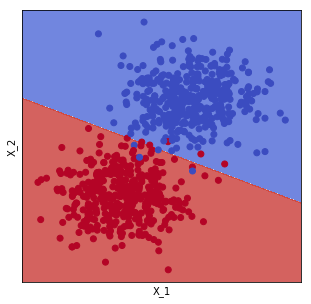

In [23]:
# DO NOT CHANGE
# Visualize decision boundary

visualize_decision_boundary(X_train, y_train)

## 5.4 Feature Mapping (5 Pts - Bonus for all)

As we can see above, our model is able to achieve a good acuracy on dataset whose most datapoints are linearly seperable. Let's see another dataset where the datapoint can't be classified with a good accuracy using a linear classifier. Run the below cell to generate the dataset.

We will also see what happens when we try to fit a linear classifier to the dataset.

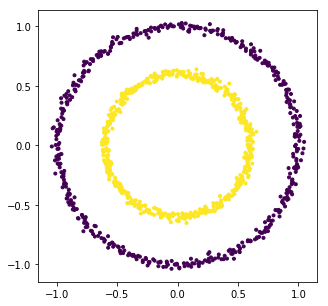

In [24]:
# DO NOT CHANGE
# Generate dataset

random_state = 1

X, y = make_circles(n_samples = 1000, 
                    noise = 0.02, 
                    random_state=random_state, 
                    factor=0.6) 

y = np.where(y == 0, -1, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=random_state)

f, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c = y, marker = '.') 
plt.show() 

Epoch is:0 and Cost is: 999.9869611947097
Epoch is:20 and Cost is: 999.7266227238711
Accuracy on test dataset: 0.36


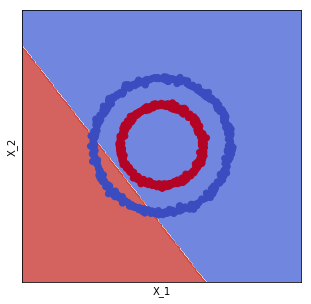

In [25]:
# DO NOT CHANGE
# Try to fit a linear classifier to the dataset

svm_cls = SVM(lr=1e-7)
svm_cls.fit(X_train, y_train)
y_test_predicted = svm_cls.predict(X_test)

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, 
                                                           y_test_predicted)))

visualize_decision_boundary(X_train, y_train)

We can see that we need a non-linear boundary to be able to successfully classify data in this dataset. In the function below add additional features which can help classify in the above dataset. After creating the additional features use code in the further cells to see how well the features perform on the test set.

In [29]:
def create_nl_feature(X):
    '''
    TODO - Create additional features and add it to the dataset
    
    returns:
        X_new - (N, d + num_new_features) array with 
                additional features added to X such that it
                can classify the points in the dataset.
    '''


In [30]:
# DO NOT CHANGE
# Create new features

X_new = create_nl_feature(X)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, 
                                                    test_size=0.20, 
                                                    random_state=random_state)

TypeError: Expected sequence or array-like, got <class 'NoneType'>

Epoch is:0 and Cost is: 999.9869611947097
Epoch is:20 and Cost is: 999.7266227238711
Accuracy on test dataset: 0.36


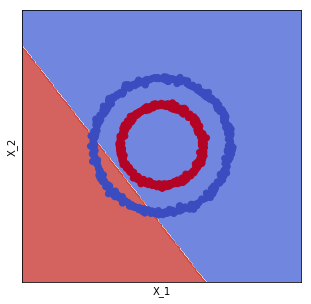

In [31]:
# DO NOT CHANGE
# Fit to the new features and vizualize the decision boundary
# You should get more than 90% accuracy on test set

svm_cls = SVM(lr=1e-7)
svm_cls.fit(X_train, y_train)
y_test_predicted = svm_cls.predict(X_test)

print("Accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))

visualize_decision_boundary(X_train, y_train, create_nl_feature)

# Part 6 Naive Bayes and Logistic Regression (30 Pts)
## 6.1 Naive Bayes (20 points)
Suppose we want to go to a golf court. However, the golf court is only open in certain weathers. Here you have the data for the last 10 days:


| Outlook  | Temperature | Windy  | Court  |
|---|---|---|---|
| Rainy | 50 | False | Closed |
| Rainy | 30 | True | Closed |
| Overcast | 20 | False | Open |
| Sunny | 10 | False | Open |
| Sunny | 30 | False | Open |
| Overcast | 50 | True | Closed |
| Sunny | 20 | True | Open |
| Rainy | 40 | False | Closed |
| Sunny | 40 | True | Closed |
| Rainy | 10 | False | Open |


(1) (3 points) Estimate the parameters for each conditional distribution P($X_i$|Y ) using maximum likelihood estimation, where $X_i$ is the individual feature, and Y is the class label. 

For example, assume P(Outlook|Y ) follows a multinomial distribution, then for Y = Open:  
P(Rainy | Open) = 1/5   
P(Overcast | Open) = 1/5  
P(Sunny | Open) = 3/5  

Estimate P(Outlook|Y ) for Y = Closed, where P(Outlook|Y ) is a multinomial distribution.
<br>
<font color='red'>
    P(Rainy|Closed)=3/5 <br>
    P(Overcast|Closed)=1/5 <br>
    P(Sunny|CLosed)=1/5
</font>
<br>
<br>

(2) (4 points) Assume P(Windy|Y ) is a Bernoulli distribution with parameter $\sigma_Y$ , (i.e., P(Windy=True|Y ) = $\sigma_Y$ and P(Windy=False|Y ) = $1 − \sigma_Y$ ), please estimate $\sigma_Y$ for both Y = Open and Y = Closed.
<br>
<font color='red'>
    P(Windy=True|Open)=1/5 <br>
    P(Windy=False|Open)=4/5 <br>
    $\sigma_O= 1/5$ <br>
    <br>
    P(Windy=True|Closed)=3/5 <br>
    P(Windy=False|Closed)=2/5 <br>
    $\sigma_C= 3/5$ 
</font>
<br>
<br>

(3) (5 points) Assume P(Temperature|Y ) is a uniform distribution in the range of $[l_Y , h_Y ]$, thus the
density P(Temperature|Y ) = $\frac{1}{h_Y −l_Y}$.
Please estimate $[l_Y , h_Y ]$ for both Y = Open and Y = Closed.
<br>
<font color='red'>
    P(Temperature $ \in [10 , 30 ]$ |Open)=1/(30-10)= 1/20 <br>
    P(Temperature $ \notin [10 , 30 ]$ |Open)=0 <br><br>
    P(Temperature $ \in [30 , 50 ]$ |Closed)=1/(50-30)= 1/20 <br>
    P(Temperature $ \notin [30 , 50 ]$ |Closed)=0 
</font>
<br>
<br>

(4) (8 points) Use Naive Bayes method to estimate if golf court will be open on a day with parameters (Overcast, 30, False).
<br>
<font color='red'>
    We have to determine which is greater between P(Open|Overcast, 30, False) and P(Closed|Overcast, 30, False). <br><r>
    Using bayes rule, P(Open|Overcast, 30, False) = $\frac{P(Overcast, 30, False|Open)P(Open)}{P(Overcast, 30, False)}$
    and P(Closed|Overcast, 30, False) = $\frac{P(Overcast, 30, False|Closed)P(Closed)}{P(Overcast, 30, False)}$ <br><br>
    assuming independence among features, and canceling the denominators (since the are the same), the court will be open if: <br><br> $P(Overcast|Open)P(30|Open)P(False|Open)P(Open) > P(Overcast|Closed)P(30|Closed)P(False|Closed)P(Closed)$ <br><br> $P(Overcast|Open)P(30|Open)P(False|Open)P(Open)= \frac{1}{5} * \frac{1}{20} * \frac{4}{5} * \frac{1}{2}=  \frac{4}{2500}$ <br><br>
 <br> $P(Overcast|Open)P(30|Open)P(False|Open)P(Open)= \frac{1}{5} * \frac{1}{20} * \frac{2}{5} * \frac{1}{2}=  \frac{2}{2500}$ <br><br> 
    since $\frac{2}{2500} > \frac{2}{2500}$, <strong>the court will be open</strong>
</font>

## 6.2 Logistic Regression (10 points)
(1) (2 points) Is Logistic Regression a discriminative or generative model? Why?
<br>
<font color='red'>
    Logistic Regression is a discriminative model as it directly esimates the decision boundary/ posterior distribution from the input without any assumption about the independence of features.
</font>
<br>
<br>
(2) (3 points) Can you apply Logisitic Regression for more than two classes? How?
<br>
<font color='red'>
    Yes, you can apply Logisitic Regression for more than two classes. There are multiple ways of doing so. One way would be to use the softmax function instead of the sigmoid function for the cross entropy loss. Another way to do so would be to train a logistic regression model for each of the classes, and select the class that has the highest probability.
</font>
<br>
<br>
(3) (5 points) Will Logisitic Regression work well for the following sets of data? Why or why not?  
Data 1:  
$(x_1 = 3, x_2 = 1, y =1), (x_1= 0, x_2 = 0, y =-1), (x_1 = -1, x_2 = -3, y = 1), (x_1 = 1, x_2 = 1, y = -1), (x_1 = 2, x_2 = 0, y = 1), (x_1 = -2, x_2 = 1, y = -1)$  
Data 2:  
$(x_1 = 2, x_2 = 1, y =1), (x_1= 0, x_2 = 0, y =-1), (x_1 = -1, x_2 = -3, y = 1), (x_1 = 1, x_2 = 1, y = 1), (x_1 = 2, x_2 = 0, y = -1), (x_1 = -2, x_2 = 1, y = -1)$
<br>
<font color='red'>
    Logistic regression will work well with Data 1, as the points have a linear decision boundary. Logistic regression will not work well with Data 2, as it seems to have a non linear decsion boundary.
</font>